## Artículos Interesantes

Veamos acá cómo está distribuido el odio según las notas

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import django
from tqdm.auto import tqdm

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

sys.path.append("..")
os.environ['DJANGO_SETTINGS_MODULE'] = 'news_labelling.settings'
django.setup()

from api.models import Comment, ArticleLabel, CommentLabel, Article, Batch
from django.contrib.auth.models import User

823


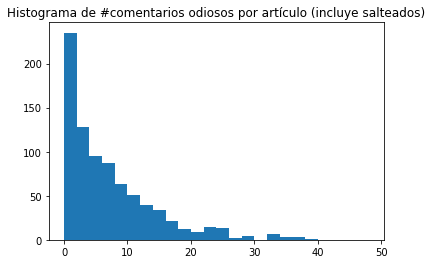

In [2]:
from matplotlib import pyplot as plt

hist = []
users = ["asilva", "dvalado", "gclerici", "gdamill", "lprats", "fdesanctis"]

article_labels = ArticleLabel.objects.prefetch_related('comment_labels').filter(
    user__username__in=users,
    
).exclude(
    article__batch__name="training"
)

label_stats = {
    
}

for article_label in article_labels:
    hateful_comments = sum([c.is_hateful for c in article_label.comment_labels.all()])
    label_stats[article_label] = hateful_comments
    
plt.hist(label_stats.values(), bins=range(0, 50, 2), range=[0, 50])
plt.title("Histograma de #comentarios odiosos por artículo (incluye salteados)")
print(len(label_stats))

Y si vemos el máximo por cada artículo?

total = 409


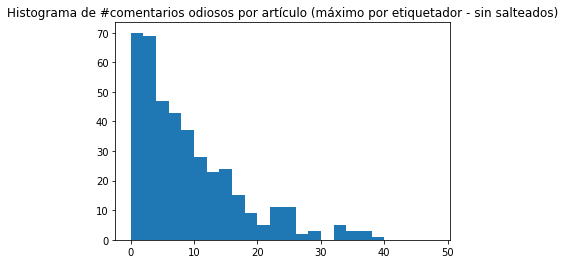

In [3]:
article_stats = {
    
}

was_skipped = set()

for article_label in article_labels:
    article = article_label.article
    
    if not article_label.is_interesting:
        was_skipped.add(article)
        continue
        
    hateful_comments = sum([c.is_hateful for c in article_label.comment_labels.all()])
    
    article_stats[article] = max(
        article_stats.get(article, 0),
        hateful_comments,
    )

plt.hist(article_stats.values(), bins=range(0, 50, 2), range=[0, 50])
plt.title("Histograma de #comentarios odiosos por artículo (máximo por etiquetador - sin salteados)")
print(f"total = {len(article_stats)}")

Los comentarios de <= 3 comentarios odiosos son muchos (los dos primeros bins)

Veamos qué pasa ahí

In [4]:
%%capture
not_so_terrible = [article for article, hateful_comments in article_stats.items() if hateful_comments <= 2]

not_so_terrible = sorted(not_so_terrible, key=lambda x: article_stats[x])
print(len(not_so_terrible))

for article in not_so_terrible:
    print("="*80)
    print(article.title, "\n")
    hateful_labels = CommentLabel.objects.filter(
        comment__article=article,
        article_label__user__username__in=users,
        is_hateful=True
    )


    for label in hateful_labels:
        print(label, end="\n\n")


Veamos los que tienen 4 o 5

In [5]:
%%capture
some_articles = [article for article, hateful_comments in article_stats.items() if 4 <= hateful_comments <= 5]

some_articles = sorted(some_articles, key=lambda x: article_stats[x])
print(len(some_articles))

for article in some_articles:
    print("="*80)
    print(article.title, "\n") 
    print(f"Artículos marcados como posiblemente odiosos = {article_stats[article]}\n\n")
    
    print("Etiquetas")
    print("---------\n")
    hateful_labels = CommentLabel.objects.filter(
        comment__article=article,
        article_label__user__username__in=users,
        is_hateful=True
    )


    for label in hateful_labels:
        print(label, end="\n\n")


## Ideas

Las que tienen 4 o 5 parecen más interesantes.

Si un artículo lo marcan dos, y como máximo hay 3 comentarios odiosos => descartar

Ahora, veamos qué pasó con los salteos


# Salteados

In [6]:
len(was_skipped)

107

¿Cuántos artículos fueron salteados pero también etiquetados por otro etiquetador?

In [7]:
skipped_and_annotated = [article for article in was_skipped if article in article_stats]
not_skipped = [article for article in article_stats if article not in skipped_and_annotated]

print(f"Hay {len(was_skipped)} artículos que fueron salteados")
print(f"Hay {len(skipped_and_annotated)} artículos que fueron anotados y salteados a la vez ")

Hay 107 artículos que fueron salteados
Hay 93 artículos que fueron anotados y salteados a la vez 


Text(0.5, 1.0, 'Distribución de comentarios odiosos')

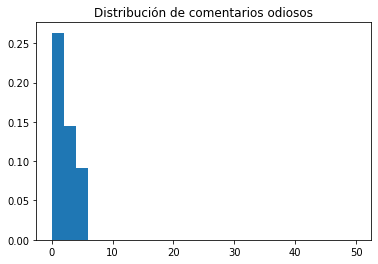

In [8]:
skipped_stats = [article_stats[art] for art in skipped_and_annotated]
not_skipped_stats = [article_stats[art] for art in not_skipped]
plt.hist(skipped_stats, range=[0, 50], bins=25, density=True, label="Skipped")
#plt.hist(not_skipped_stats, range=[0, 50], bins=25, density=True, label="Not Skipped")

plt.title("Distribución de comentarios odiosos")

In [9]:
print("Cantidad de comentarios odiosos anotados en comentarios también salteados")
for i in range(6):
    C = sum(1 for art in skipped_and_annotated if article_stats[art] <= i)
    print(f"#Odiosos menores iguales a {i}: {C}")

Cantidad de comentarios odiosos anotados en comentarios también salteados
#Odiosos menores iguales a 0: 21
#Odiosos menores iguales a 1: 49
#Odiosos menores iguales a 2: 65
#Odiosos menores iguales a 3: 76
#Odiosos menores iguales a 4: 83
#Odiosos menores iguales a 5: 93


In [10]:
articles = sorted(skipped_and_annotated, key=lambda x: article_stats[x])
for article in articles:
    if article_stats[article] != 4:
        continue
    print("="*80)
    print(article.title, "\n")
    hateful_labels = CommentLabel.objects.filter(
        comment__article=article,
        article_label__user__username__in=users,
        is_hateful=True
    )


    for label in hateful_labels:
        print(label, end="\n\n")


Oscar González Oro, harto de la cuarentena: "El día que se pueda me voy a Uruguay" 

asilva sobre '@usuario Te vamos a extrañar negrito...

Na, ni te registro grasun'
Odioso  -> ['ASPECTO']

asilva sobre '@usuario Viejo trolo, milito esta mierda y ahora huye como lo q es, una rata.'
Odioso  -> ['LGBTI', 'ASPECTO']

asilva sobre '@usuario Andate y no vuelvas, gorila negro!'
Odioso  -> ['POLITICA', 'ASPECTO']

asilva sobre '@usuario Puto malo!!! ... es jodido....'
Odioso  -> ['LGBTI']

Se separaron Marcelo Tinelli y Guillermina Valdés 

asilva sobre '@usuario uff los gatos q se le van a tirar a tinelli.....'
Odioso  -> ['MUJER']

asilva sobre '@usuario Se dió cuenta que al pelotudo le gusta la bala justo hoy dia del orgullo jajaja'
Odioso  -> ['LGBTI']

asilva sobre '@usuario Seguramente Guillermina se terminó de dar cuenta q al cuervo le gustan los pebetes y el zodape más que conducir Showmatch'
Odioso  -> ['LGBTI']

asilva sobre '@usuario el viejo idiota de Tinelli ya no está xa mujer 

In [11]:
sum(skipped_stats)

171

Pocos, casi que no vale la pena

Fijémonos que la mayoría tienen <= 3 comentarios odiosos

In [12]:
Article.objects.filter(labels__is_interesting=False).distinct().count()

107

In [13]:
for art in sorted(skipped_and_annotated, key=lambda x: article_stats[x]):
    skipped = art.labels.filter(is_interesting=False)
    annotated = art.labels.filter(is_interesting=True)
    
    print("="*80)
    print(art.title, "\n")
    
    print(article_stats[art], " comentarios odiosos")
    print(f"Anotaron : {' - '.join(label.user.username for label in annotated)}")
    print(f"Saltearon: {' - '.join(label.user.username for label in skipped)}")

Maximiliano Guerra criticó las medidas del Gobierno: "Si esto no es comunismo, ¿qué es?" 

0  comentarios odiosos
Anotaron : asilva
Saltearon: dvalado
Los salarios le ganaron a la inflación por más de 4 puntos en enero 

0  comentarios odiosos
Anotaron : asilva
Saltearon: dvalado
Escándalo en el Congreso: escena sexual del diputado kirchnerista Juan Emilio Ameri en plena sesión virtual 

0  comentarios odiosos
Anotaron : gclerici
Saltearon: dvalado
En Tucumán, la nueva ley antimotochorros introduce con un cambio clave: estará prohibido que dos adultos viajen en una moto 

0  comentarios odiosos
Anotaron : gclerici
Saltearon: dvalado
Alberto Fernández: “Querían salir a correr y a pasear, salgan, ahí están las consecuencias” 

0  comentarios odiosos
Anotaron : lprats
Saltearon: dvalado
Raúl Zaffaroni: “Los medios cumplen la función de un partido único, como el de Hitler” 

0  comentarios odiosos
Anotaron : gclerici
Saltearon: dvalado
Patricia Bullrich, tras el banderazo 17A: "Hoy nosotro

In [14]:
print(f"Artículos salteados = {len(was_skipped)}")
for article in sorted(skipped_and_annotated, key=lambda x: article_stats[x]):
    hateful_labels = CommentLabel.objects.filter(
        comment__article=article,
        article_label__user__username__in=users,
        is_hateful=True
    )
    if hateful_labels.count() == 0:
        continue
        
    print("="*80)
    print(article.title, "\n") 
    print(f"Artículos marcados como posiblemente odiosos = {article_stats[article]}\n\n")
    
    print("Etiquetas")
    print("---------\n")
    

    for label in hateful_labels:
        print(label, end="\n\n")

Artículos salteados = 107
Reestructuración en Coca-Cola: la empresa desmiente un traslado de sus operaciones en Argentina en medio de rumores 

Artículos marcados como posiblemente odiosos = 1


Etiquetas
---------

asilva sobre '@usuario Suele pasar que las empresas ven zurdos y huyen despavoridos. En fin, triste por los argentinos que a penas inician en el viaje largo y horroroso al desastre y la desolacion.'
Odioso  -> ['POLITICA']

La OMS pidió ahora evitar las cuarentenas como método principal para controlar el avance del coronavirus 

Artículos marcados como posiblemente odiosos = 1


Etiquetas
---------

asilva sobre '@usuario La droga que consumen es legal? Que manga de hdp'
Odioso  -> ['DISCAPACIDAD']

Yanina Latorre se une a Lizardo Ponce, Martín Cirio y su hija Lola para hacer un show por streaming 

Artículos marcados como posiblemente odiosos = 1


Etiquetas
---------

asilva sobre '@usuario Ya con ver que va a estar el mogolico de La Faraona deduzco y afirmo que va a ser 

# Batch 6

El batch 6 lo asignamos a 3 de una... veamos qué pasó ahí

In [15]:
articles = Article.objects.filter(batch__name="6", labels__is_interesting=False)

for art in sorted(articles, key=lambda x: article_stats[x]):
    skipped = art.labels.filter(is_interesting=False)
    annotated = art.labels.filter(is_interesting=True)
    print("="*80)
    print(art.title, "\n")
    
    print(article_stats[art], " comentarios odiosos")
    print(f"Anotaron : {' - '.join(label.user.username for label in annotated)}")
    print(f"Saltearon: {' - '.join(label.user.username for label in skipped)}")

Coronavirus en Argentina: volvían de Brasil y cambiaron los carteles de los micros para evitar la cuarentena, pero fueron detenidos 

1  comentarios odiosos
Anotaron : gclerici - asilva
Saltearon: gdamill
La Argentina, el segundo país peor ubicado en un ranking internacional de miseria económica 

1  comentarios odiosos
Anotaron : asilva - gclerici
Saltearon: gdamill
El primer detenido por caminar por la calle durante la cuarentena total: “No tengo que darle explicaciones a nadie” 

2  comentarios odiosos
Anotaron : asilva - gclerici
Saltearon: gdamill
El virólogo que ganó el premio Nobel por descubrir el VIH aseguró que el nuevo coronavirus fue creado en un laboratorio 

4  comentarios odiosos
Anotaron : gclerici - asilva
Saltearon: gdamill
Tras las críticas del kirchnerismo duro, Alberto Fernández llamará a Maduro para explicarle la condena argentina en la ONU 

5  comentarios odiosos
Anotaron : asilva - gclerici
Saltearon: gdamill


In [16]:
print(f"Artículos salteados = {len(was_skipped)}")
i = 1
for article in sorted(skipped_and_annotated, key=lambda x: article_stats[x]):
    hateful_labels = CommentLabel.objects.filter(
        comment__article=article,
        article_label__user__username__in=users,
        is_hateful=True
    )
    
    comments = {label.comment for label in hateful_labels}
    if len(comments) <= 4:
        continue
        
    print("="*80)
    print(i, "- ", article.title, "\n") 
    print(f"Artículos marcados como posiblemente odiosos = {article_stats[article]}\n\n")
    
    print("Etiquetas")
    print("---------\n")
    i+=1

    for label in hateful_labels:
        print(label, end="\n\n")

Artículos salteados = 107
1 -  El virólogo que ganó el premio Nobel por descubrir el VIH aseguró que el nuevo coronavirus fue creado en un laboratorio 

Artículos marcados como posiblemente odiosos = 4


Etiquetas
---------

gclerici sobre '@usuario Convengamos q nadie se chupa los dedos era más q evidente q los chinos crearon su propio Virus Chinos.'
Odioso  -> ['RACISMO']

gclerici sobre '@usuario Obvio! ya hace mucho tiempo que lo dijo el presidente Trump! esto es una guerra de China, la tercera guerra mundial que ataca humanos y a la economía. Abrir los comercios porque la pandemia económica va a ser peor que la del virus, que es lo que China quiere solo destruir'
Odioso  -> ['RACISMO']

asilva sobre '@usuario Premio Nobel o no, claramente está medio gagá o bien le pusieron money en el pocket para que diga cualquier pelotudez los que buscan armar bardo con China.'
Odioso  -> ['ASPECTO']

gclerici sobre '@usuario por supuesto, esto es terrorismo para tod☀️s ..ahh y todas! (que solo 